Deep Mind has publihsed a new method of hyperparameter optimizaion in the paper titiled ["Population Based Training of Neural Networks"](https://arxiv.org/pdf/1711.09846.pdf). Its overview is explained concisely in [their blog post](https://deepmind.com/blog/population-based-training-neural-networks/).

In this article, after going through the concept briefly, I would like to demonstrate how to implement PBT with tensorflow.

Let's start from figuring out the concept!!

# Population Based Training

###  What is different from the other optimization algorithms?

Roughly speaking, PBT(population based training) provides the way to optimize parameters with the only single execution. More specifically speaking for neural network, we do not necessary have to set the number of epochs of gradient decsent algorithms. 

Let's see how it works by compaison with others.
As most typical optimization algorithms, we have grid-, random-, and Bayesian optimization.

Grid optimization is well-known the most basic method. Although it may work well on small dimensional space, but the execution time blows up exponentially as the dimension increases. 

Random optimization is considered as one of the effective methods to optimize high dimensional space like hyperparameters of neural network [paper1](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).
Besdes that this method is easily parallelizable. The combination of many-armed bandit, hyperband, achieves state-of-art result[paper3](https://arxiv.org/pdf/1603.06560.pdf). 

Bayesian optimization is a method to sample trial parameters [paper2](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf). This method iterates estimate of defined cost functions over search spaces and try the primising parameters. Seqential optimization like Bayesian optimization will in general provide the best solution. This method can be sped up by parallelizations [paper4](https://arxiv.org/pdf/1606.04414.pdf). 

Hyperband and parallel Bayesian optimization can be considered as two of the best ways to optimize hyperparameters.

The drawback that these methods above have in common needs to run multiple training, which requires huge computational resources. 
PBT inpired by genetic algorithm comes in to solve this problem. As long as a candidate keeps good performance, PBT allows it to keep run training. Besides that, we can adapt hyperparameters like learning rate during training. This is helpful when dealing with transitional distribution data like reinforcement learning.
Here is the figure from the original paper:

![PBT](PBT.pnb)

To clear the difference more, let's consider random and Bayesian optimization with the same number of parallerization as that of population of PBT. First, becuase of greedy search, we can expect PBT to have better perfomance than random optimization. Bayesian method may sample parameters more effectively. Even if it finds the good set of hyperparameters, we have to restart training from scratch if we try to rain modles with longer trining execution(i.e., the number of epochs for grdienct descent. Thus, we consider PBT as an effective method to optimize neural network.


### How to implement PBT?
PBT is implemented in the following procedures:


1. Build population, in which each candidates is set up with randomly generated hyperparameters.
2. Run up to a certain period for each candidate.
3. Compare its performance with others'
4. Replace it with the better paramters if necessary and add noise to the new setting

Repeat 3. and 4. procedures. According to the original paper, resampling instead of just adding noise is also allowed to have explore more other options. Comparison also not necessary happen at the same time over all wokers.
The size of population is typically from 10 to 40 acccording to the original paper. run multiple agents with parameters 


Here is the pseudo code from the paper.
![pbt_algo](ewr)

# Toy Models


To show how to implement it in the simple way, we start from a toy model used in the original paper. Here is the problem. We consider optimizing the following two dimensional function:
$$ Q(\theta) = 1.2 - (\theta_0^2 + \theta_1^2)$$

In [2]:
import tensorflow as tf

def objective(theta): 
    return 1.2 - tf.reduce_sum(theta ** 2)

/home/tom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We assume here that we are unable to access to the information about how the fucntion acutually looks like, which mean this is black box optimization problems. As an approximation, we propose the following surrogate function:
$$ \hat{Q}(\theta | h) = 1.2 - (h_0 \theta_0^2 + h_1 \theta_1^2)$$

In [3]:
def surrogate_objective(theta, h):
    return 1.2 - tf.reduce_sum((h * theta) ** 2)

First, we have to implement each agent, which has step, explore and exploit functions.

In the step function, we optimize traininable parameters given hyperparameters, $\theta$ in this example.
The exploit function chooses workers according to a certain criteria. For the sake of simplicity, this example chooses a worker with the best performance. 
The explore function adds the noise to hyperparameter $h$ by gaussian noise. 


Implementation referenced [this repository](https://github.com/bkj/pbt/blob/master/pbt.ipynb)

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfe.enable_eager_execution()

In [5]:
class Worker(object):
    def __init__(self, theta, h, objective, surrogate_objective, id):
        self.theta = theta
        self.h = h
        self.objective = objective
        self.surrogate_objective = surrogate_objective
        self.id = id
        
        self._lr = 1e-2
        self._grad = tfe.gradients_function(self.surrogate_objective)
        self._history = dict(theta=[], h=[], score=[])
        
    @property
    def history(self):
        return dict(theta=np.vstack(self._history["theta"]),
                    h=np.vstack(self._history["h"]),
                    score=np.vstack(self._history["score"]))
    
    def _log(self):
        self._history['theta'].append(self.theta.copy())
        self._history['h'].append(self.h.copy())
        self._history['score'].append(self.eval())
        
    def step(self):
        self._log()
        grad_theta, grad_h = self._grad(self.theta, self.h)
        # Update tunable parameters by GD
        d_theta = self._lr * grad_theta
        self.theta += d_theta.numpy()
        
    def eval(self):
        return self.objective(self.theta).numpy()
    
    def exploit(self, population):
        current_scores = [dict(id=woker.id, score=woker.eval()) for woker in population]
        best_worker = sorted(current_scores, key=lambda x: x["score"])[-1]
        
        if best_worker["id"] != self.id:
            best_worker = population[best_worker["id"]]
            self.theta = best_worker.theta.copy()
            # We do not copy hyperparameters in this example
            # self.h = population[best_worker["id"]].h.copy()
            
    def explore(self, sd=0.1):
        self.h += np.random.normal(0, sd, size=[2])

In [6]:
def run_experiment(do_explore=False, do_exploit=False, interval=5, n_steps=200):
    
    # Create population
    population = [
        Worker(
            theta=np.array([0.9, 0.9]),
            h=np.array([1.0, 0.0]),
            objective=objective,
            surrogate_objective=surrogate_objective,
            id=0,
        ),
        Worker(
            theta=np.array([0.9, 0.9]),
            h=np.array([0.0, 1.0]),
            objective=objective,
            surrogate_objective=surrogate_objective,
            id=1,
        ),
    ]
    
    # Training part can be parallelized
    # Train
    for step in range(n_steps):
        for worker in population:
            if not (step + 1) % interval:
                
                if do_exploit:
                    worker.exploit(population)
                    
                if do_explore:
                    worker.explore()
            
            worker.step()
    
    return population

In [14]:
# Run experiments w/ various PBT settings
np.random.seed(0)
pbt = run_experiment(do_explore=True, do_exploit=True) # Explore and exploit
explore = run_experiment(do_explore=True, do_exploit=False) # Explore only
exploit = run_experiment(do_explore=False, do_exploit=True) # Exploit only
grid = run_experiment(do_explore=False, do_exploit=False) # regular grid search

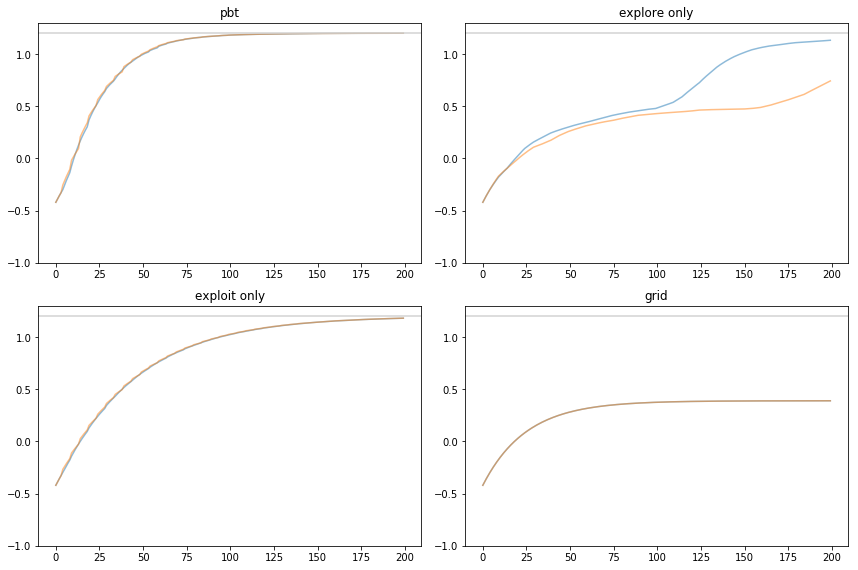

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_score(ax, workers, run_name):
    """ Plot performance """
    for worker in workers:
        history = worker.history
        _ = ax.plot(history['score'], label="%s worker %d" % (run_name, worker.id), alpha=0.5)
    
    _ = ax.set_title(run_name)
    _ = ax.set_ylim(-1, 1.3)
    _ = ax.axhline(1.2, c='lightgrey')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plot_score(ax1, pbt, 'pbt')
plot_score(ax2, explore, 'explore only')
plot_score(ax3, exploit, 'exploit only')
plot_score(ax4, grid, 'grid')
_ = plt.tight_layout(pad=1)
plt.show()

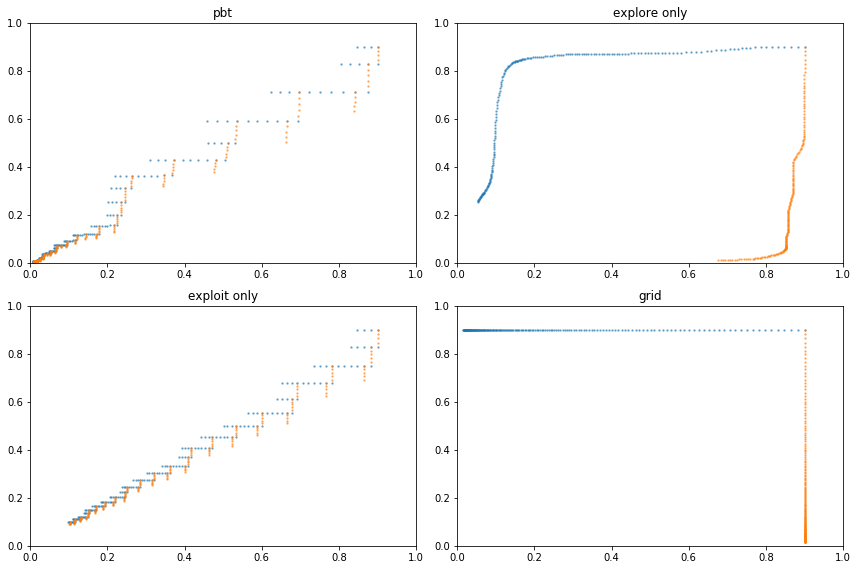

In [16]:
def plot_theta(ax, workers, run_name):
    """ Plot values of theta """
    for worker in workers:
        history = worker.history
        _ = ax.scatter(history['theta'][:,0], history['theta'][:,1], 
            s=2, alpha=0.5, label="%s worker %d" % (run_name, worker.id))
    
    _ = ax.set_title(run_name)
    _ = ax.set_xlim(0, 1)
    _ = ax.set_ylim(0, 1)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plot_theta(ax1, pbt, 'pbt')
plot_theta(ax2, explore, 'explore only')
plot_theta(ax3, exploit, 'exploit only')
plot_theta(ax4, grid, 'grid')
_ = plt.tight_layout(pad=1)
plt.show()

As you see in the above figures, the main improvement comes from the exploitation and the exploration adds only small modification. 

# Optimize Neural Network

Implementation comes form [this repository](https://github.com/MattKleinsmith/pbt) and [this repository](https://github.com/saschaschramm/PopulationBasedTraining). 


In [14]:
import numpy as np

def transform(x, conf):
    if conf == "log_continuous":
        x = 10**x
    elif conf == "integer":
        x = int(np.ceil(x))
    elif conf == "log_integer":
        x = int(np.ceil(10**x))
    return x


def inverse_transform(x, conf):
    if conf == "log_continuous":
        x = np.log10(x)
    elif conf == "log_integer":
        x = np.log10(x)
    return x


def _random_sample(params_conf):
    """Sample parameters at random with dictionary format

    Parameters
    ----------
    params_conf: list(dict) or dict

    Returns
    -------
    params_dict : dict
        key is a name of each parameter
    """
    if len(params_conf) == 0 or not isinstance(params_conf[0], list):
        params_conf = [params_conf]
    params_conf = random.sample(params_conf, k=1)[0]
    params_dict = {}
    for conf in params_conf:
        name = conf["name"]
        domain = conf["domain"]
        type_ = conf["type"]
        if type_ == "log_continuous":
            param = 10 ** np.random.uniform(domain[0], domain[1])
        elif type_ == "continuous":
            param = np.random.uniform(domain[0], domain[1])
        elif type_ == "log_integer":
            param = int(10 ** np.random.uniform(domain[0], domain[1]))
        elif type_ == "integer":
            param = np.random.randint(domain[0], domain[1] + 1)
        elif type_ == "categorical":
            param = random.sample(domain, k=1)[0]
        param = inverse_transform(param, type_)
        params_dict[name] = param
    return params_dict


def random_sample(params_conf, x=None):
    if x is None:
        x = defaultdict(lambda: None)
    if isinstance(params_conf, dict):
        for key, conf in params_conf.items():
            x[key] = random_sample(conf, x[key])
    else:
        x = _random_sample(params_conf)
    return x

In [13]:
from tensorflow.contrib import keras
from copy import deepcopy
import gc

def build_model(params):
    model = keras.models.Sequential()
    for param in params:
        param = deepcopy(param)
        name = param["name"].lower()
        del param["name"]
        if name = "dense":
            model.add(keras.layers.Dense(**param))
        elif name == "conv2d":
            model.add(keras.layers.Conv2D(**param))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
            
            

class Worker:
    def __init__(self, id, params, performance=None):
        self.id = id
        self.performance = performance
        self.build_model(params)
        
    def build_model(self, params):
        self.model = build_model(params)
        
    def fit(self, X, y, resource):
        self.model.fit(X, y, batch_size=self.batch_size, epochs=resource)
        
    def eval(self, X, y):
        score = self.model.evaluate(X, y, batch_size=self.batch_size)
        return score
    
    
        
        
class Manager:
    def __init__(self, save_dir, population):
        self.save_dir = save_dir
        
    def resume_model(self, id):
        pass
    
    def save_model(self, id):
        pass
    
    def train_model(self, id, resource):
        worker = population[id]
        worker.fit(self.X, self.y, epochs=resource)
    
    
def generate_parmas():
    params_conf = [{"name": "num_layer", "type": "integer", "domain": (1, 10)},
                   {"name": "num_units", "type": "log_integer", "domain": (0, 3)},
                   {"name": "learning_rate", "type": "log_continuous", "domain": (-1, -5)}]
    params = random_sample(params_conf)
    return params


def generate_noise():
    params_conf = [{"name": "num_layer", "type": "integer", "domain": (-1, 1)},
                   {"name": "num_units", "type": "integer", "domain": (-200, 200)},
                   {"name": "learning_rate", "type": "log_continuous", "domain": (-5, -1)}]
    params = random_sample(params_conf)
    return params


def explore(config, mutations, resample_probability, custom_explore_fn):
    """Return a config perturbed as specified.
    Args:
        config (dict): Original hyperparameter configuration.
        mutations (dict): Specification of mutations to perform as documented
            in the PopulationBasedTraining scheduler.
        resample_probability (float): Probability of allowing resampling of a
            particular variable.
        custom_explore_fn (func): Custom explore fn applied after built-in
            config perturbations are.
    """
    new_config = copy.deepcopy(config)
    for key, distribution in mutations.items():
        if isinstance(distribution, list):
            if random.random() < resample_probability or \
                    config[key] not in distribution:
                new_config[key] = random.choice(distribution)
            elif random.random() > 0.5:
                new_config[key] = distribution[
                    max(0, distribution.index(config[key]) - 1)]
            else:
                new_config[key] = distribution[
                    min(len(distribution) - 1,
                        distribution.index(config[key]) + 1)]
        else:
            if random.random() < resample_probability:
                new_config[key] = distribution()
            elif random.random() > 0.5:
                new_config[key] = config[key] * 1.2
            else:
                new_config[key] = config[key] * 0.8
            if type(config[key]) is int:
                new_config[key] = int(new_config[key])
    if custom_explore_fn:
        new_config = custom_explore_fn(new_config)
        assert new_config is not None, \
            "Custom explore fn failed to return new config"
    print(
        "[explore] perturbed config from {} -> {}".format(config, new_config))
    return new_config

def run_experiment(X, y, validate_X, validate_y, num_popualtion=20,
                   num_epochs=100, interval=10, ratio=0.2):
    # Initialize population
    population = dict()
    for i in range(num_popualtion):
        params = generate_params()
        worker = Worker(id=i, params=params)
        population[i] = worker
    
    num_try = num_epochs // interval
    for i in range(num_try):
        accuracies = dict()
        for key, worker in population.items():
            worker.fit(X, y, interval)
            accuracies[key] = worker.eval(validate_X, validate_y)
        num_survive = max(1, int(ratio * num_population))
        srot_idx = np.argsort(list(accuracies.values()))[::-1]
        top_idx = sort_idx[:num_survive]
        top_keys = list(population.keys())[top_idx]
        bottom_idx = sort_idx[num_survive:]
        bottom_keys = list(population.keys())[bottom_idx]
        for key in bottom_keys:
            # Exploitation
            worker = population[key]
            del worker.model
            gc.collect()
            best_key = np.random.choice(top_keys)
            best_params = population[best_key].get_params()
            worker.build_model(best_params)
            # Exploration
            

SyntaxError: invalid syntax (<ipython-input-13-1b79d9d27f45>, line 11)

In [56]:
import numpy as np

np.random.choice([-1, 0, 1], p=[0.25, 0.5, 0.25])

0

In [10]:
tf.reset_default_graph()

In [5]:
def square(x):
    return tf.multiply(x, x)

In [6]:
grad = tfe.gradients_function(square)
grad(3.)

[<tf.Tensor: id=11, shape=(), dtype=float32, numpy=6.0>]

In [13]:
m.numpy()

array([[4.]], dtype=float32)

In [14]:
m


<tf.Tensor: id=2, shape=(1, 1), dtype=float32, numpy=array([[4.]], dtype=float32)>

In [18]:
def test_func(x, y):
    return(x + y)**2

In [21]:
grad = tfe.gradients_function(test_func)
x = tf.placeholder(tf.float32)
y = tf.palcehodler(tf.float32)
grad(x, y)

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [1]:
import numpy as np

In [18]:
import random
random.random()

0.6853389164238846

In [14]:
from sklearn import datasets

data = datasets.load_iris()

In [16]:
data.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [2]:
X = |

SyntaxError: invalid syntax (<ipython-input-2-938a4ea820c4>, line 1)

In [3]:
from hedgeable_ai.functions.preprocessing import Imputer

In [4]:
imp = Imputer()

In [5]:
imp.model_type

'Imputer'

In [6]:
[].insert(0, 3)

In [9]:
x = []
x.insert(0, 3)
x

[3]

In [13]:
import numpy as np
X[0][0] = np.nan
np.isfinite(X).all()

False

In [3]:
import numpy as np

np.vstack(([[1,2], [3, 4]], [[1], [3], [5]]))

ValueError: all the input array dimensions except for the concatenation axis must match exactly